In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
import math
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
df = pd.read_csv("db/mathematics-articles.csv")[:10000]
tokenizer = WordPunctTokenizer()
df['tokens'] = df['article_name'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['n_tokens'] = df['tokens'].apply(len)

In [3]:
max_length = 25
df = df.loc[df['n_tokens'] <= max_length].reset_index(drop=True)

In [4]:
all_tokens = np.sum(np.array(df['tokens'].tolist()))
freq = Counter(all_tokens)
n_tokens = 10000
top_tokens = dict(freq.most_common(n_tokens))

In [5]:
tokens =  ['<sos>', '<eos>', '<pad>', '<unk>'] + list(top_tokens.keys())
token2idx = {token: i for i, token in enumerate(tokens)}
idx2token = {i: token for token, i in token2idx.items()}

In [6]:
def tokenize(x):
    padding = [token2idx['<pad>']] * (max_length - len(x))
    def if_unk(token):
        return token if token in token2idx else '<unk>'
    return [token2idx[if_unk(token)] for token in ['<sos>'] + x[:max_length]] + padding + [token2idx['<eos>']]

data = np.array(df['tokens'].apply(lambda x: np.array(tokenize(x))).tolist())

In [7]:
def get_batch(X, batch_size):
    idx = np.random.choice(X.shape[0], size=batch_size)
    return X[idx]

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

In [10]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [14]:
model = TransformerModel(len(tokens), 300, 2, 200, 2, 0.5)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
history = []
criterion = nn.CrossEntropyLoss()

In [20]:
batch = torch.Tensor(get_batch(data, 10)).long()

src_mask = model.generate_square_subsequent_mask(10)
logp_seq = model(batch, src_mask)
loss = criterion(logp_seq[:, :-1].contiguous().view(-1, len(tokens)), 
    batch[:, 1:].contiguous().view(-1))

loss.backward()
loss

tensor(9.2412, grad_fn=<NllLossBackward>)

In [25]:
torch.Tensor(get_batch(data, batch_size)).long()

torch.Size([128, 27])

In [26]:
epochs = 20
batch_size = 128
history = []

for e in range(epochs):
    num_it = len(data) // batch_size
    train_loss = 0.
    
    for it in tqdm(range(num_it)):
        batch = torch.Tensor(get_batch(data, batch_size)).long()
        src_mask = model.generate_square_subsequent_mask(batch_size)
        
        opt.zero_grad()
        
        out = model(batch, src_mask)
        
        loss = criterion(
            out[:, :-1].contiguous().view(-1, len(tokens)), 
            batch[:, 1:].contiguous().view(-1))
        
        loss.backward()
        
        train_loss += loss.item()
        opt.step()
        
    history.append(train_loss / len(data))

100%|██████████| 77/77 [02:06<00:00,  1.65s/it]


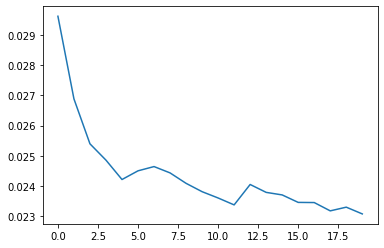

In [27]:
import matplotlib.pyplot as plt
plt.plot(history)

In [30]:
def predict_next_token(model, word: str, temperature=1.0):
    tensor = torch.Tensor([[token2idx[word]]]).long().to(device)
    out = model(tensor, model.generate_square_subsequent_mask(1))[0][-1]
    # sample
    softmax = F.softmax(out / temperature, dim=-1)
    next_ix = np.random.choice(len(tokens), p=softmax.data.cpu().numpy())
    return idx2token[next_ix]

In [31]:
def generate_sentence(model, seed: str, temperature=1.0):
    next_token = predict_next_token(model, seed, temperature)
    sentence = [seed, next_token]
    while next_token not in ('<eos>', '<pad>') and len(sentence) <= max_length:
        next_token = predict_next_token(model, next_token, temperature)
        sentence.append(next_token)
    return list(filter(lambda x: x not in ['<sos>', '<pad>', '<unk>', '<eos>'], sentence))

In [37]:
generate_sentence(model, '<sos>', temperature=0.99)

['к',
 'решению',
 'в',
 'графов',
 'вероятностей',
 'в',
 'краевой',
 'на',
 'некоторые',
 'паде',
 'n']